In [ ]:
#from keras.applications.resnet import ResNet50, ResNet101
from keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Dense, Dropout, merge, Conv2D, Input, concatenate, Conv2DTranspose

from keras.models import Model, load_model

import PIL
from keras import backend as keras



In [7]:
import os
import random
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [3]:
def png_to_mask(mask_path, img_size=(128,128), cut=True):
    mask_img = PIL.Image.open(mask_path)
    if cut:
        mask_array = np.array(mask_img)
        mask_array = mask_array[0:img_size[0], :]
    else:    
        mask_img = mask_img.resize((img_size[1], img_size[0]))
        mask_array = np.array(mask_img)
    
    unique, counts = np.unique(mask_array, return_counts=True)
    mask_list = []
    for i in unique:
        mask_0 = mask_array==i
        mask_0 = mask_0.astype('float32')       
        mask_list.append(mask_0)
        
    return np.stack(mask_list, -1) 


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)    


   

In [4]:
def print_res(res):
    plt.figure(figsize=(10,10))
    for i in range(res.shape[-1]):
        plt.grid(False)
        plt.subplot(5,5, 1+i)
        plt.title(str(i))
        plt.imshow(res[0,:,:,i])

In [ ]:
model_t = load_model('models/netherland_inlines_320x768.hdf5', custom_objects={'dice_coef_loss':dice_coef_loss, 'dice_coef': dice_coef})

In [ ]:
#img = PIL.Image.open('/home/core/Public/ilines/1744_ilines.png', )
#img = load_img('/home/core/Public/netherland/inlines_png/inline_102.png', color_mode = "grayscale")
#img = load_img('/home/core/Public/ilines/1737_ilines.png', color_mode = "grayscale")
img = load_img('/home/core/Public/netherland/inlines_png/inline_108.png', color_mode = "grayscale")

#mask = load_img('/home/core/Public/netherland/masks/inline_108_mask.png', color_mode = "grayscale")
mask = load_img('/home/haimin/kaggle/gas_oil/trap_seismic_dataset/masks/4209_xlinescustom.png', color_mode = "grayscale")



x_img = img_to_array(img)
x_img = resize(x_img, (320, 768, 1), mode='constant', preserve_range=True)
x_img = np.expand_dims(x_img, 0)
print(np.amax(x_img), np.mean(x_img))
x_img.shape

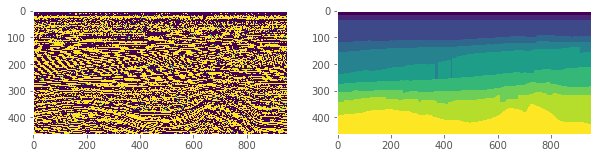

In [44]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.grid(False)
plt.imshow(x_img[0,:,:,0])
plt.subplot(122)
plt.grid(False)
plt.imshow(mask)

In [ ]:
mask_im = 

In [11]:
res = model_t.predict(x_img)
res.shape

(1, 320, 768, 10)

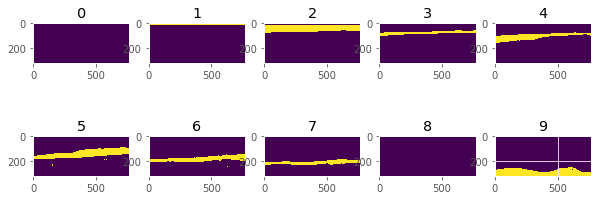

In [12]:
print_res(res)

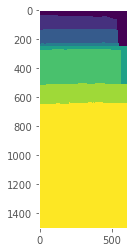

In [84]:
plt.grid(False)
#mask = load_img('/home/core/Public/penobscote/masks/masks/crossline_1008_mask.png')
mask = PIL.Image.open('/home/core/Public/penobscote/masks/masks/crossline_1008_mask.png')
plt.imshow(np.array(mask))



In [6]:
# Get and resize train images and masks
def get_data(path, train=True, num_classes=10, img_size=(128,128), cut=True):
    ids = next(os.walk(path + "inlines_png"))[2]
    X = np.zeros((len(ids), img_size[0], img_size[1], 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), img_size[0], img_size[1], num_classes), dtype=np.float32)
    print('Getting and resizing images ... ')
    print('cut to {} ... '.format(img_size[0]))

    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
     
        # Load images
        img = load_img(path + 'inlines_png/' + id_, color_mode = "grayscale")
        x_img = img_to_array(img)
        if cut:
            x_img = x_img[0:img_size[0],:]
            x_img = np.expand_dims(x_img, -1)
        else:    
            x_img = resize(x_img, (img_size[0], img_size[1], 1), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = png_to_mask(path + '/masks/' + id_.split('.')[0] + '_mask.png', img_size=img_size, cut=cut )
            #mask = resize(mask, (128, 128, num_classes), mode='constant', preserve_range=True)
            

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = mask
    print('Done!')
    if train:
        return X, y
    else:
        return X
    


In [105]:
#X, y = get_data('netherland/', img_size=(320,768), num_classes=10, cut=False)

Getting and resizing images ... 
cut to 320 ... 


/home/core/anaconda3/envs/integral/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



Done!


In [106]:
np.save('netherland/netherland_inlines_320x768_X.npy', X)
np.save('netherland/netherland_inlines_320x768_y.npy', y)

In [21]:
!ls

11111.ipynb	     eee		  models	       penobscote
crossline_X_320.npy  gas_oil_colab.ipynb  modelsunet_320.hdf5
crossline_y_320.npy  ilines		  netherland


In [5]:
X = np.load('netherland/netherland_inlines_320x768_X.npy')
y = np.load('netherland/netherland_inlines_320x768_y.npy')

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2018)

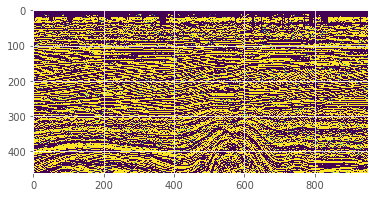

In [56]:
plt.imshow(X_valid[9,:,:,0])

In [0]:
#!pip install keras-resnet
#import keras
#import keras_resnet.models

In [0]:
def resnet_34_unet(input_shape, num_classes):
    model = keras_resnet.models.ResNet34(x, classes=classes)
    extractor = Model(inputs=model.input, outputs=model.get_layer('res5b2_relu').output)
    conv_5 = Conv2D(1024, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(extractor.output)
    conv_5 = Conv2D(1024, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_5)
    dropout_5 = Dropout(0.1)(conv_5)
# upsampling part

  up1 = UpSampling2D(size=(2,2))(dropout_5)
  merge_1 = concatenate([up1, extractor.get_layer('res4b5_relu').output]) #14x14@224
  conv_6 = Conv2D(512, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(merge_1)
  conv_6 = Conv2D(512, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_6)
  dropout_6 = Dropout(0.1)(conv_6)

  up2 = UpSampling2D(size=(2,2))(dropout_6)
  merge_2 = concatenate([up2, extractor.get_layer('res3b3_relu').output]) #28x28 @224
  conv_7 = Conv2D(256, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(merge_2)
  conv_7 = Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_7)
  dropout_7 = Dropout(0.1)(conv_7)

  up3 = UpSampling2D(size=(2,2))(dropout_7)
  merge_3 = concatenate([up3, extractor.get_layer('res2b2_relu').output]) #56x56@224
  conv_8 = Conv2D(128, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(merge_3)
  conv_8 = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_8)
  dropout_8 = Dropout(0.1)(conv_8)

  up4 = UpSampling2D(size=(2,2))(dropout_8)
  merge_4 = concatenate([up4, extractor.get_layer('conv1_relu').output]) #112x112@224
  conv_9 = Conv2D(64, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(merge_4)
  conv_9 = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_9)
  dropout_9 = Dropout(0.1)(conv_9)

  up5 = UpSampling2D(size=(2,2))(dropout_9)
  merge_5 = concatenate([up5, extractor.get_layer(index=0).output]) #224x224@224
  conv_10 = Conv2D(64, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(merge_5)
  conv_10 = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_10)


  conv_11 = Conv2D(num_classes, 1, activation = 'sigmoid')(conv_10)

  return Model(input = extractor.input, output = conv_11)




In [7]:
def all_droput_unet(input_shape, num_classes):
    inputs = Input((input_shape[0], input_shape[1], input_shape[2]))
    conv_1 = Conv2D(64, (3,3), strides=(1,1),padding='same', activation='relu', kernel_initializer='he_normal')(inputs)
    conv_1 = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(conv_1)
    dropout_1 = Dropout(0.1)(conv_1)
    pool_1 = MaxPooling2D(pool_size=(2,2))(dropout_1)
    conv_2 = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(pool_1)
    conv_2 = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(conv_2)
    dropout_2 = Dropout(0.1)(conv_2)
    pool_2 = MaxPooling2D(pool_size=(2,2))(dropout_2)
  
    conv_3 = Conv2D(256, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(pool_2)
    conv_3 = Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_3)
    dropout_3 = Dropout(0.1)(conv_3)
    pool_3 = MaxPooling2D(pool_size=(2,2))(dropout_3)

    conv_4 = Conv2D(512, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(pool_3)
    conv_4 = Conv2D(512, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_4)
    dropout_4 = Dropout(0.1)(conv_4)
    pool_4 = MaxPooling2D(pool_size=(2,2))(dropout_4)

    conv_5 = Conv2D(1024, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(pool_4)
    conv_5 = Conv2D(1024, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_5)
    dropout_5 = Dropout(0.1)(conv_5)

  #upsampling

    up1 = UpSampling2D(size=(2,2))(dropout_5)
    merge_1 = concatenate([up1, dropout_4])
    conv_6 = Conv2D(512, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(merge_1)
    conv_6 = Conv2D(512, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_6)
    dropout_6 = Dropout(0.1)(conv_6)

    up2 = UpSampling2D(size=(2,2))(dropout_6)
    merge_2 = concatenate([up2, dropout_3])
    conv_7 = Conv2D(256, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(merge_2)
    conv_7 = Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_7)
    dropout_7 = Dropout(0.1)(conv_7)

    up3 = UpSampling2D(size=(2,2))(dropout_7)
    merge_3 = concatenate([up3, dropout_2])
    conv_8 = Conv2D(128, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(merge_3)
    conv_8 = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_8)
    dropout_8 = Dropout(0.1)(conv_8)

    up4 = UpSampling2D(size=(2,2))(dropout_8)
    merge_4 = concatenate([up4, dropout_1])
    conv_9 = Conv2D(64, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(merge_4)
    conv_9 = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_9)
    dropout_9 = Dropout(0.1)(conv_9)

    conv_10 = Conv2D(num_classes, 1, activation = 'sigmoid')(conv_9)

    return Model(input = inputs, output = conv_10)





In [8]:
model_dir = 'models/'

model_checkpoint = ModelCheckpoint(model_dir+'netherland_inlines_320x768.hdf5', 
                                   monitor='loss', 
                                  
                                   verbose=1, 
                                   save_best_only=True) 

model = all_droput_unet((320,768,1),10)

model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, \
                  metrics=[dice_coef, 'accuracy'])
results = model.fit(X_train, y_train, batch_size=4, epochs=20, callbacks=[model_checkpoint, 
                                             EarlyStopping(patience=7, verbose=1),],
                                              validation_data=(X_valid, y_valid))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.






/home/core/anaconda3/envs/integral/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`





Train on 553 samples, validate on 98 samples
Epoch 1/20





553/553 [==============================] - 138s 249ms/step - loss: -0.3182 - dice_coef: 0.3182 - acc: 0.1674 - val_loss: -0.4591 - val_dice_coef: 0.4591 - val_acc: 0.1456

Epoch 00001: loss improved from inf to -0.31818, saving model to models/netherland_inlines_320x768.hdf5
Epoch 2/20
553/553 [==============================] - 126s 228ms/step - loss: -0.5348 - dice_coef: 0.5348 - acc: 0.3234 - val_loss: -0.5838 - val_dice_coef: 0.5838 - val_acc: 0.3675

Epoch 00002: loss improved from -0.31818 to -0.53479, saving model to models/netherland_inlines_320x768.hdf5
Epoch 3/20
553/553 [==============================] - 127s 230ms/step - loss: -0.5925 - dice_coef: 0.5925 - acc: 0.5078 - val_loss: -0.5947 - val_dice_coef: 0.5947 - val_acc: 0.4538

Epoch 00003: loss improved from -0.53479 to -0.59253, saving model to models/netherland_inlines_320x768.hdf5
Epoch 4/20
553/553 [==============================] - 127s 230ms/step - loss

In [0]:
def all_convolutional_unet(input_shape, num_classes):
    inputs = Input((input_shape[0], input_shape[1], input_shape[2]))
    conv_1 = Conv2D(64, (3,3), strides=(1,1),padding='same', activation='relu', kernel_initializer='he_normal')(inputs)
    conv_1 = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(conv_1)
    dropout_1 = Dropout(0.1)(conv_1)

    conv_1 = Conv2D(64, 2,strides=(2,2) ,padding='same', activation='relu', kernel_initializer='he_normal')(dropout_1)

    conv_2 = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(conv_1)
   conv_2 = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(conv_2)
  dropout_2 = Dropout(0.1)(conv_2)

  conv_2 = Conv2D(128, 2, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal')(dropout_2)  

  
  conv_3 = Conv2D(256, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(conv_2)
  conv_3 = Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_3)
  dropout_3 = Dropout(0.1)(conv_3)

  conv_3 = Conv2D(256, 2, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal')(dropout_3)

  conv_4 = Conv2D(512, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(conv_3)
  conv_4 = Conv2D(512, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_4)
  dropout_4 = Dropout(0.1)(conv_4)
  conv_4 = Conv2D(512, 2, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal')(dropout_4)

  conv_5 = Conv2D(1024, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(conv_4)
  conv_5 = Conv2D(1024, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_5)
  dropout_5 = Dropout(0.1)(conv_5)

  #upsampling

  up1 = UpSampling2D(size=(2,2))(dropout_5)
  merge_1 = concatenate([up1, dropout_4])
  conv_6 = Conv2D(512, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(merge_1)
  conv_6 = Conv2D(512, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_6)
  dropout_6 = Dropout(0.1)(conv_6)

  up2 = UpSampling2D(size=(2,2))(dropout_6)
  merge_2 = concatenate([up2, dropout_3])
  conv_7 = Conv2D(256, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(merge_2)
  conv_7 = Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_7)
  dropout_7 = Dropout(0.1)(conv_7)

  up3 = UpSampling2D(size=(2,2))(dropout_7)
  merge_3 = concatenate([up3, dropout_2])
  conv_8 = Conv2D(128, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(merge_3)
  conv_8 = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_8)
  dropout_8 = Dropout(0.1)(conv_8)

  up4 = UpSampling2D(size=(2,2))(dropout_8)
  merge_4 = concatenate([up4, dropout_1])
  conv_9 = Conv2D(64, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(merge_4)
  conv_9 = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_9)
  dropout_9 = Dropout(0.1)(conv_9)

  conv_10 = Conv2D(num_classes, 1, activation = 'sigmoid')(conv_9)

  return Model(input = inputs, output = conv_10)





In [0]:
def all_inverted_unet(input_shape, num_classes):
  inputs = Input((input_shape[0], input_shape[1], input_shape[2]))
  conv_1 = Conv2D(256, (3,3), strides=(1,1),padding='same', activation='relu', kernel_initializer='he_normal')(inputs)
  conv_1 = Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(conv_1)
  dropout_1 = Dropout(0.1)(conv_1)
  pool_1 = MaxPooling2D(pool_size=(2,2))(dropout_1)
  conv_2 = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(pool_1)
  conv_2 = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(conv_2)
  dropout_2 = Dropout(0.1)(conv_2)
  pool_2 = MaxPooling2D(pool_size=(2,2))(dropout_2)
  
  conv_3 = Conv2D(64, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(pool_2)
  conv_3 = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_3)
  dropout_3 = Dropout(0.1)(conv_3)
  pool_3 = MaxPooling2D(pool_size=(2,2))(dropout_3)

  conv_4 = Conv2D(32, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(pool_3)
  conv_4 = Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_4)
  dropout_4 = Dropout(0.1)(conv_4)
  pool_4 = MaxPooling2D(pool_size=(2,2))(dropout_4)

  conv_5 = Conv2D(16, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(pool_4)
  conv_5 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_5)
  dropout_5 = Dropout(0.1)(conv_5)

  #upsampling

  up1 = UpSampling2D(size=(2,2))(dropout_5)
  merge_1 = concatenate([up1, dropout_4])
  conv_6 = Conv2D(32, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(merge_1)
  conv_6 = Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_6)
  dropout_6 = Dropout(0.1)(conv_6)

  up2 = UpSampling2D(size=(2,2))(dropout_6)
  merge_2 = concatenate([up2, dropout_3])
  conv_7 = Conv2D(64, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(merge_2)
  conv_7 = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_7)
  dropout_7 = Dropout(0.1)(conv_7)

  up3 = UpSampling2D(size=(2,2))(dropout_7)
  merge_3 = concatenate([up3, dropout_2])
  conv_8 = Conv2D(128, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(merge_3)
  conv_8 = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_8)
  dropout_8 = Dropout(0.1)(conv_8)

  up4 = UpSampling2D(size=(2,2))(dropout_8)
  merge_4 = concatenate([up4, dropout_1])
  conv_9 = Conv2D(2256, 3 , padding='same', activation='relu', kernel_initializer='he_normal')(merge_4)
  conv_9 = Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_9)
  dropout_9 = Dropout(0.1)(conv_9)

  conv_10 = Conv2D(num_classes, 1, activation = 'sigmoid')(conv_9)

  return Model(input = inputs, output = conv_10)

